In [1]:
##要执行的我会在代码段前注释“第i步”
#第一步
import numpy
import pandas as pd
import datetime
import json
import os
import xlrd# 安装xlrd == 1.2.0 版本太高会出错
import numpy as np
import matplotlib.pyplot as plt
import copy
from skyfield.api import load, EarthSatellite
from skyfield.api import wgs84
from matplotlib.pyplot import MultipleLocator
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

### No need to run

In [2]:
def get_allfile(path):  # 获取所有文件
    all_file = []
    for f in os.listdir(path):  #listdir返回文件中所有目录
        f_name = os.path.join(path, f)
        all_file.append(f_name)
    return all_file

In [25]:
key_wanted=["NORAD_CAT_ID","OBJECT_NAME","EPOCH","INCLINATION","TLE_LINE1","TLE_LINE2","SEMIMAJOR_AXIS"]
tickets = r"..\..\Dataset\all_by_time_2019_5_22_2022_7_20\all_csv"
all_file=get_allfile(tickets)  #tickets要获取文件夹名
for i in range(len(all_file)):#  94,107 or 346,385
    filename=r"%s"%all_file[i]
    if(i == 0):tle_df = pd.read_csv(filename)
    else:
        tle_mid_df = pd.read_csv(filename)
        tle_df = pd.concat([tle_df,tle_mid_df],join='outer',axis=0)

name_list = []
for i in range(len(list(tle_df.columns))):
    if(list(tle_df.columns)[i] not in key_wanted):
        name_list.append(list(tle_df.columns)[i])

tle_df = tle_df.drop(columns=name_list)
# for i in range(len(tle_df)):
#     tle_df.iloc[i,2] = datetime.datetime.strptime(tle_df.iloc[i,2],"%Y-%m-%d %H:%M:%S")

#提取到tle后按“NORAD_CAT_ID”分组，并按EPOCH的逆序排序
tle_group = tle_df.groupby("NORAD_CAT_ID")
object_dict = {}
for dfGroupBy in tle_group:
    df_dict_key = dfGroupBy[0]
    df_dict_value = pd.DataFrame(dfGroupBy[1])
    object_dict[df_dict_key] = df_dict_value.sort_values(by='EPOCH',ascending=False)
#print(starlink_dict['STARLINK-3282'])

In [20]:
# key_list = [48357,51935]
# for key in object_dict.keys():
#     if(object_dict[key].iloc[0,1] == 'STARLINK-1057'):print('1:',object_dict[key].iloc[0,0])
#     if(object_dict[key].iloc[0,1] == 'ONEWEB-0052'):print('2:',object_dict[key].iloc[0,0])
#     if(object_dict[key].iloc[0,1] == 'STARLINK-1683'):print('3:',object_dict[key].iloc[0,0])
#     if(object_dict[key].iloc[0,1] == 'COSMOS 1461'):print('4:',object_dict[key].iloc[0,0])
#     if(object_dict[key].iloc[0,1] == 'STARLINK-1062'):print('5:',object_dict[key].iloc[0,0])
#     if(object_dict[key].iloc[0,1] == 'STARLINK-1733'):print('6:',object_dict[key].iloc[0,0])

4: 14064
1: 44762
5: 44767
2: 45156
6: 46564
3: 46578


In [8]:
key_list = [48357, 51935, 44762, 45156 ,46578 ,14064 ,44767 , 46564]

In [26]:
for key in object_dict.keys():
    if(key not in key_list):continue
    object_dict[key]['alltitude'] = ''
    for i in range(len(object_dict[key])):#len(object_dict[key])
        tle_line1 = object_dict[key].iloc[i,4]
        tle_line2 = object_dict[key].iloc[i,5]
        if(type(object_dict[key].iloc[i,2]) == str):
            object_dict[key].iloc[i,2] = datetime.datetime.strptime(object_dict[key].iloc[i,2],"%Y-%m-%d %H:%M:%S")
        tle_epoch = object_dict[key].iloc[i,2]
        year = tle_epoch.year
        month = tle_epoch.month
        day = tle_epoch.day
        hour = tle_epoch.hour
        minute = tle_epoch.minute
        second = tle_epoch.second

        ts = load.timescale()
        sat = EarthSatellite(tle_line1,tle_line2,None,ts)
        t = ts.utc(year,month,day,hour,minute,second)
        geocentric = sat.at(t)
        h = wgs84.height_of(geocentric).km
        object_dict[key].iloc[i,7] = h

### Start from this line

In [2]:
object_dict = np.load('../Figure18/data/object_dict.npy',allow_pickle=True).item()

In [12]:
def cal_pos(sat_id,start_time,end_time,object_dict):
    sat_df1 = object_dict[sat_id]
    for i in range(len(sat_df1)):
        if(type(sat_df1.iloc[i,2]) == str):
            sat_df1.iloc[i,2] = datetime.datetime.strptime(sat_df1.iloc[i,2],"%Y-%m-%d %H:%M:%S")
    sat_df1 = sat_df1[(sat_df1['EPOCH'] >= (start_time - datetime.timedelta(days=3))) & (sat_df1['EPOCH'] < end_time)]
    sat_df1 = sat_df1.sort_values(by='EPOCH',ascending=False)
    #print(len(sat_df1))
    sat_pos = {}
    sat_vel = {}
    sat_h = {}
    tle_epoch = end_time
    i = 0
    # if(sat_id == 46700):
    #     print(len(sat_df1),sat_df1)
    while(i < len(sat_df1)):
        #print(i,tle_epoch)
        if(tle_epoch < start_time):
            #print('break',tle_epoch)
            break
        epoch = sat_df1.iloc[i,2]
        if(epoch >= tle_epoch):
            i += 1
            continue
        if((epoch < tle_epoch) and (tle_epoch not in sat_h.keys())):
            tle_line1 = sat_df1.iloc[i,4]
            tle_line2 = sat_df1.iloc[i,5]
            
            year = tle_epoch.year
            month = tle_epoch.month
            day = tle_epoch.day
            hour = tle_epoch.hour
            minute = tle_epoch.minute
            second = tle_epoch.second
            ts = load.timescale()
            sat = EarthSatellite(tle_line1,tle_line2,None,ts)
            t = ts.utc(year,month,day,hour,minute,second)
            geocentric = sat.at(t)
            if(tle_epoch in sat_h.keys()):continue
            #print(epoch,tle_epoch)
            h = wgs84.height_of(geocentric).km
            position = geocentric.position.km
            velocity = geocentric.velocity.km_per_s
            sat_h[tle_epoch] = h
            sat_pos[tle_epoch] = position
            sat_vel[tle_epoch] = velocity
            tle_epoch = tle_epoch - datetime.timedelta(minutes=1)
    sat_h = dict(sorted(sat_h.items(),key=lambda x:x[0]))
    sat_h = list(sat_h.values())
    sat_pos = dict(sorted(sat_pos.items(),key=lambda x:x[0]))
    sat_pos = list(sat_pos.values())
    sat_vel = dict(sorted(sat_vel.items(),key=lambda x:x[0]))
    sat_vel = list(sat_vel.values())
    return sat_pos,sat_vel

In [13]:
sat_pos_vel = {}
#key_list = {45156:oneweb_dict,44762:starlink_dict}
key_list = {48357:object_dict,51935:object_dict}
for key in key_list.keys():
    #if((key != 48357) and (key != 51935)):continue
    sat_pos_vel[key] = {'pos':[],'vel':[]}
    pos,vel = cal_pos(key,datetime.datetime(2022,5,1),datetime.datetime(2022,6,1),key_list[key])
    sat_pos_vel[key]['pos'] = pos
    sat_pos_vel[key]['vel'] = vel

In [14]:
def icrs_to_rtn(pos1,vel1,pos2,vel2):
    e_along=vel1/np.sqrt(pow(vel1[0],2)+pow(vel1[1],2)+pow(vel1[2],2))
    t=np.cross(pos1,vel1)
    e_cross=t/np.sqrt(pow(t[0],2)+pow(t[1],2)+pow(t[2],2))
    e_radial=np.cross(e_along,e_cross)
    delta_pos=pos2-pos1
    delta_vel=vel2-vel1
    rtn_pos=[np.dot(e_radial,delta_pos),np.dot(e_along,delta_pos),np.dot(e_cross,delta_pos)]
    rtn_vel=[np.dot(e_radial,delta_vel),np.dot(e_along,delta_vel),np.dot(e_cross,delta_vel)]
    return rtn_pos,rtn_vel

In [15]:
sat_rtn = {}
for key in sat_pos_vel.keys():
    sat_rtn[key] = {'pos':[],'vel':[]}
    for i in range(len(sat_pos_vel[key]['pos']) - 1):
        rtn_pos,rtn_vel = icrs_to_rtn(sat_pos_vel[key]['pos'][i],sat_pos_vel[key]['vel'][i],sat_pos_vel[key]['pos'][i + 1],sat_pos_vel[key]['vel'][i + 1])
        sat_rtn[key]['pos'].append(rtn_pos)
        sat_rtn[key]['vel'].append(rtn_vel)

In [16]:
sat_r = {}
sat_t = {}
sat_n = {}
sat_rv = {}
sat_tv = {}
sat_nv = {}
for key in sat_rtn.keys():
    sat_r[key] = []
    sat_t[key] = []
    sat_n[key] = []
    sat_rv[key] = []
    sat_tv[key] = []
    sat_nv[key] = []
    for i in range(len(sat_rtn[key]['pos'])):
        sat_r[key].append(sat_rtn[key]['pos'][i][0])
        sat_t[key].append(sat_rtn[key]['pos'][i][1])
        sat_n[key].append(sat_rtn[key]['pos'][i][2])
        sat_rv[key].append(sat_rtn[key]['vel'][i][0])
        sat_tv[key].append(sat_rtn[key]['vel'][i][1])
        sat_nv[key].append(sat_rtn[key]['vel'][i][2])

In [17]:
# 生成时间序列数组
def generate_time_series(start, end, len_wanted):
    current = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    end_item = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    interval = (end_item - current).total_seconds() / len_wanted
    time_delta = datetime.timedelta(seconds=interval) # modify
    time_series = [current]
    while current < end_item:
        next = current + time_delta
        time_series.append(next)
        current = next
    return time_series

<Figure size 432x288 with 0 Axes>

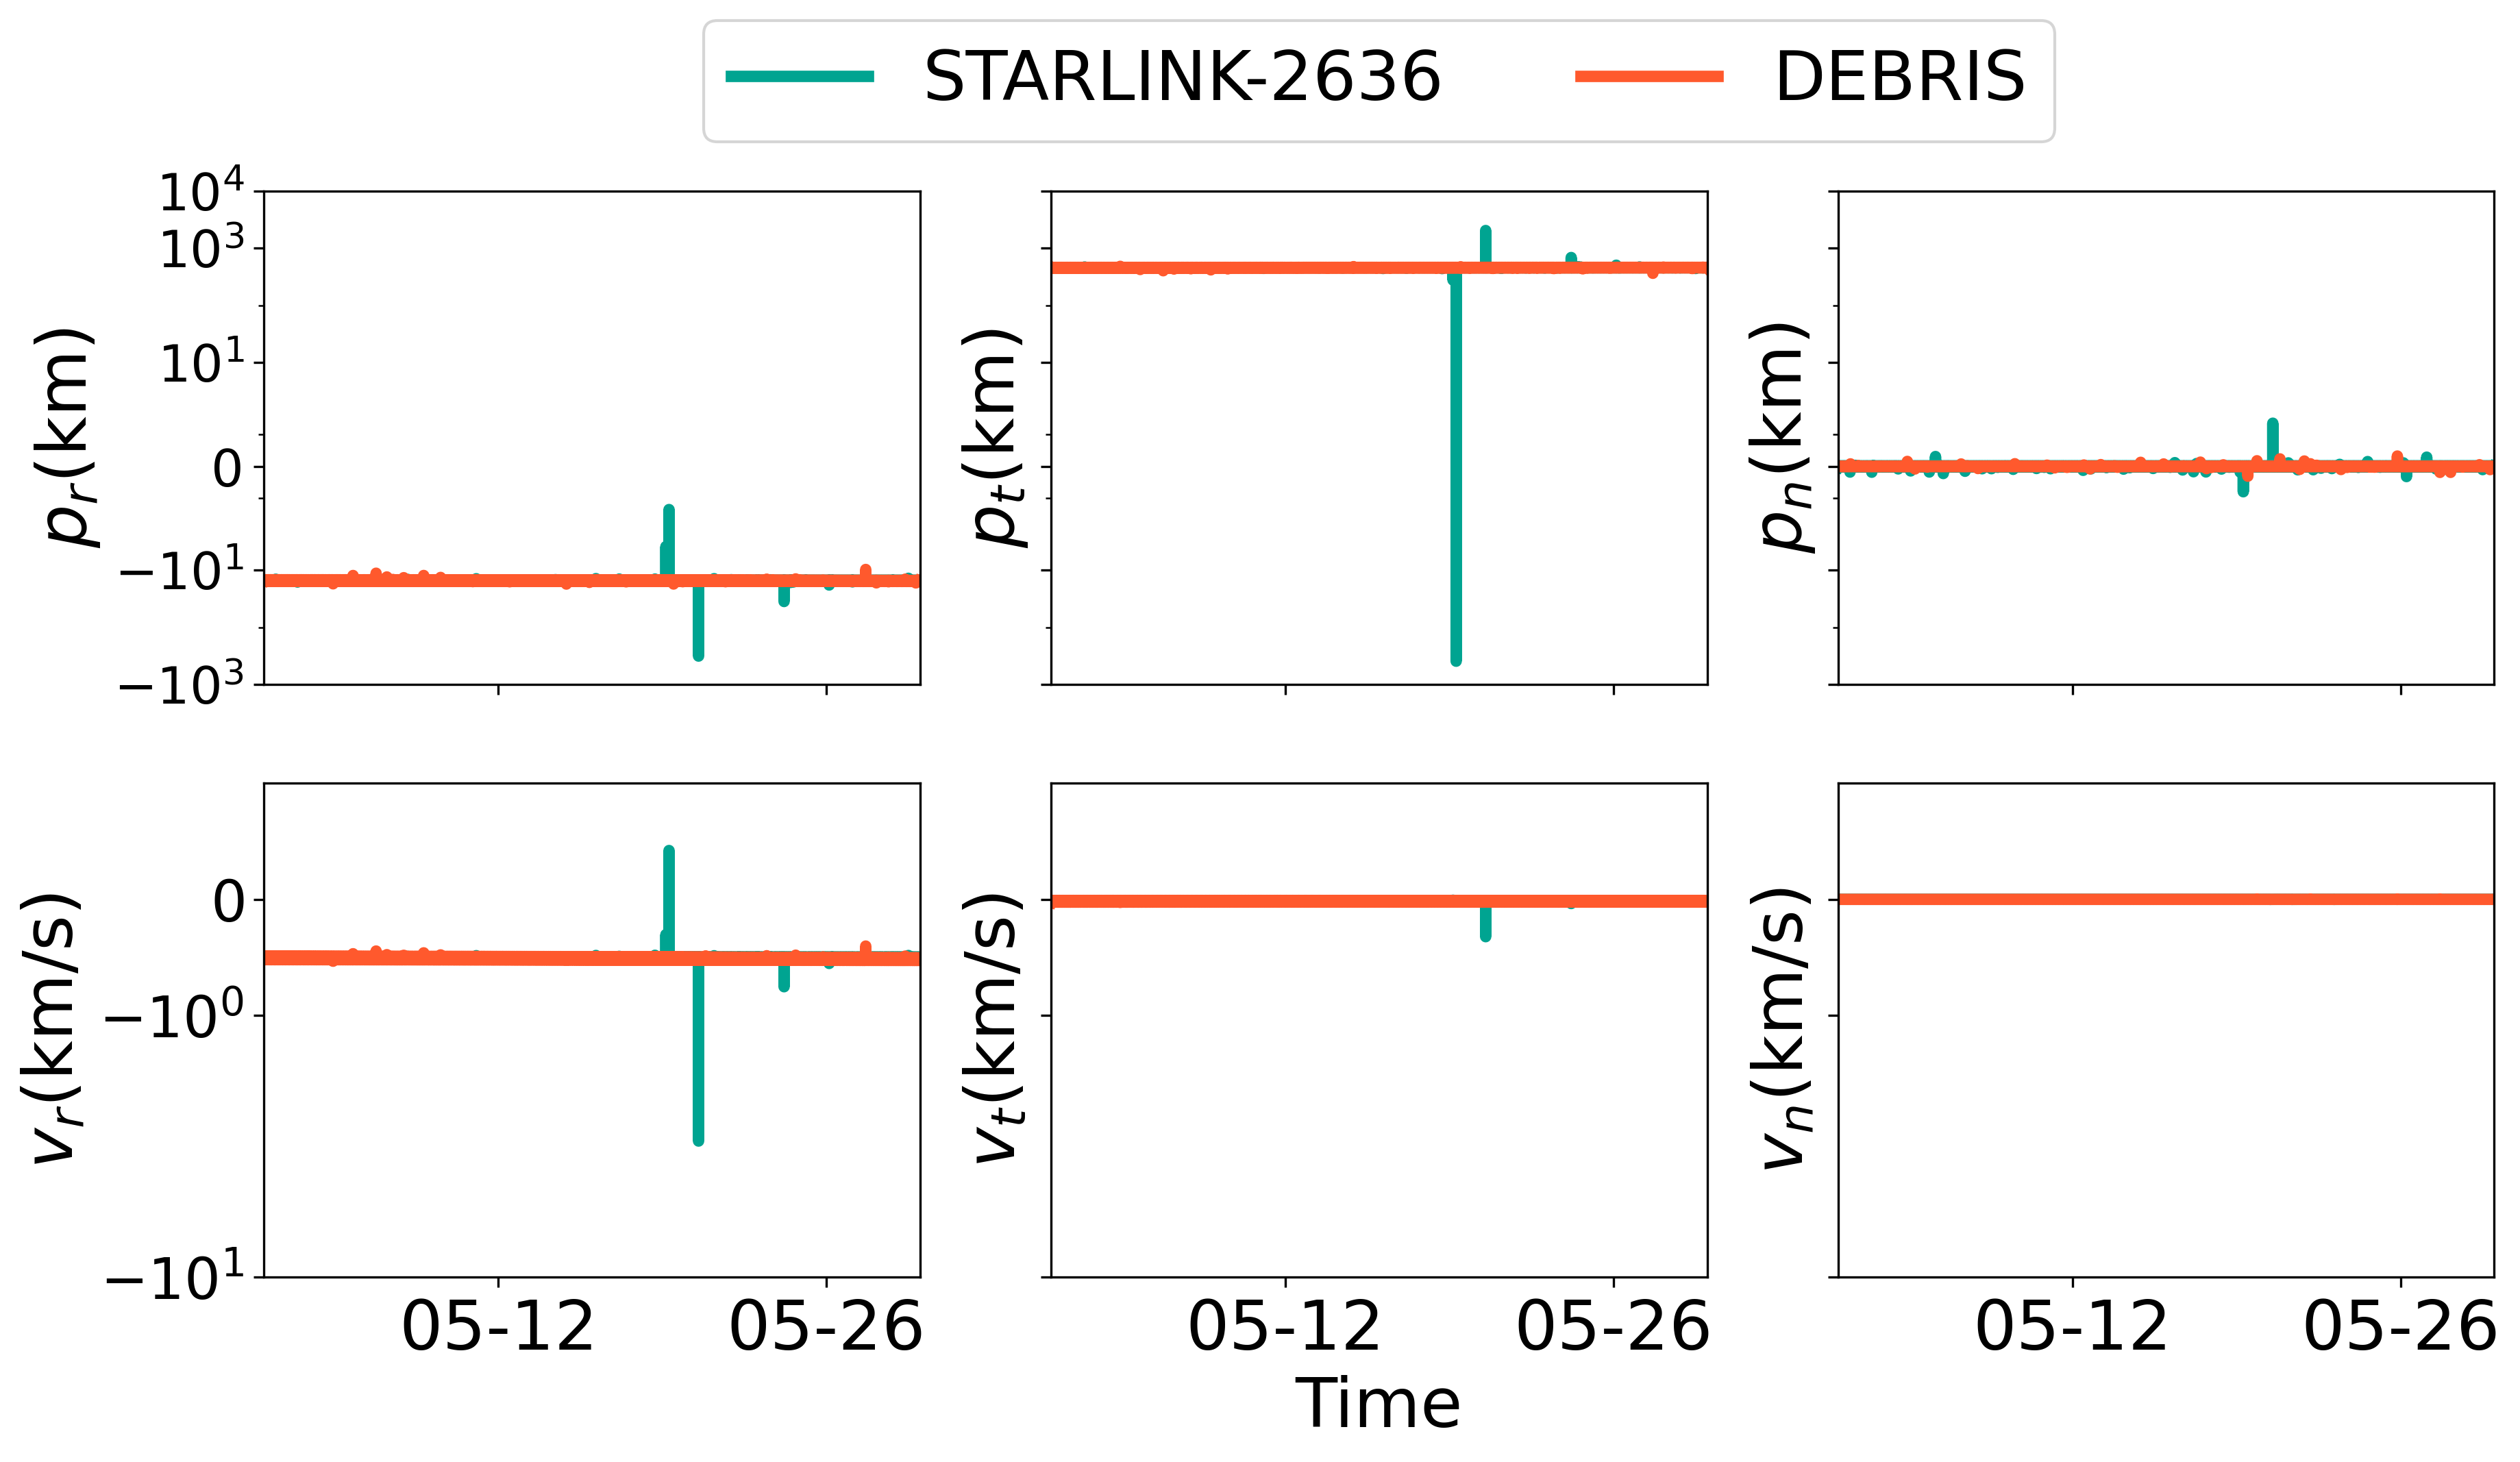

In [19]:
time_scale = generate_time_series("2022-5-1 0:0:0", "2022-6-1 0:0:0",44640)[:-1]
plt.figure(1)
fig = plt.figure(figsize=(14,7),dpi = 300)
axes = fig.subplots(2,3,sharex=True,sharey='row')
plt.subplot(231)
plt.plot(time_scale,sat_r[48357],color = "#00A491",linewidth = 4)
plt.plot(time_scale,sat_r[51935],color = "#FF592D",linewidth = 4)
#plt.legend(['STARLINK-2636','DEBRIS'])
plt.yscale('symlog',base = 10)
plt.yticks([-1000,-10,0,10,1000,10000],['${-10^3}$','${-10^1}$','0','${10^1}$','${10^3}$','${10^4}$'])
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20)
#plt.ylim(-1000,10000)
plt.ylim([-1000,10000])
#axes[0][0].yaxis.set_major_locator(mtick.LogLocator(100))
plt.ylabel('${p_r}$(km)',fontsize = 24)
axes[0][0].xaxis.set_major_locator(MultipleLocator(20))
plt.subplot(232)
plt.plot(time_scale,sat_t[48357],color = "#00A491",linewidth = 4)
plt.plot(time_scale,sat_t[51935],color = "#FF592D",linewidth = 4)
plt.legend(['STARLINK-2636','DEBRIS'],fontsize = 24,ncol = 2,bbox_to_anchor=(0.5, 1.1), loc=8, borderaxespad=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 20)
plt.ylabel('${p_t}$(km)',fontsize = 24)
axes[0][1].xaxis.set_major_locator(MultipleLocator(20))
plt.subplot(233)
plt.plot(time_scale,sat_n[48357],color = "#00A491",linewidth = 4)
plt.plot(time_scale,sat_n[51935],color = "#FF592D",linewidth = 4)
#plt.legend(['STARLINK-2636','DEBRIS'])
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 20)
plt.ylabel('${p_n}$(km)',fontsize = 24)
axes[0][2].xaxis.set_major_locator(MultipleLocator(20))
plt.subplot(234)
# plt_df = object_dict[44762]
# plt_df = plt_df[(plt_df['EPOCH'] >= datetime.datetime(2422,5,1)) & (plt_df['EPOCH'] <= datetime.datetime(2422,6,1))]
# plt.plot(plt_df['EPOCH'],plt_df['alltitude'],color = "#00A491")
plt.plot(time_scale,sat_rv[48357],color = "#00A491",linewidth = 4)
plt.plot(time_scale,sat_rv[51935],color = "#FF592D",linewidth = 4)
#plt.legend(['STARLINK-2636','DEBRIS'])
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 24)
plt.ylim([-10,1])
plt.yscale('symlog')
plt.ylabel('${v_r}$(km/s)',fontsize = 24)
axes[1][0].xaxis.set_major_locator(MultipleLocator(20))
plt.subplot(235)
plt.plot(time_scale,sat_tv[48357],color = "#00A491",linewidth = 4)
plt.plot(time_scale,sat_tv[51935],color = "#FF592D",linewidth = 4)
#plt.legend(['STARLINK-2636','DEBRIS'])
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 24)
plt.ylabel('${v_t}$(km/s)',fontsize = 24)
plt.xlabel('Time',fontsize = 24)
axes[1][1].xaxis.set_major_locator(MultipleLocator(20))
plt.subplot(236)
plt.plot(time_scale,sat_nv[48357],color = "#00A491",linewidth = 4)
plt.plot(time_scale,sat_nv[51935],color = "#FF592D",linewidth = 4)
#plt.legend(['STARLINK-2636','DEBRIS'])
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 24)
plt.ylabel('${v_n}$(km/s)',fontsize = 24)
#axes[0][1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%e'))
#axes[1][2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
axes[1][2].xaxis.set_major_locator(MultipleLocator(14))
axes[1][2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlim([datetime.datetime(2022,5,2),datetime.datetime(2022,5,30)])
#plt.tight_layout()
# axes[3].xaxis.set_major_locator(MultipleLocator(15))
# axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.savefig(r'figure19b.pdf',bbox_inches='tight',pad_inches = 0.01)